In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [283]:
import asf_search as asf
from pystac_client import Client
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, shape
from datetime import datetime
from opera_coverage import *
import geopandas as gpd
import numpy as np
from shapely.geometry import box, Point
from rasterio.crs import CRS

from tqdm import tqdm
import concurrent.futures
from typing import List

# from shapely.geometry import Polygon, shape
# from datetime import timedelta
# from typing import List
# import geopandas as gpd
# import pandas as pd

In [4]:
# in degrees
X_SPACING = 1
Y_SPACING = 0.25
RADIUS = .1

geometry = [Point(lon, lat).buffer(RADIUS)
            for lon in np.linspace(-180, 180, int(360 / X_SPACING)) 
            for lat in np.linspace(-90, 90, int(180 / Y_SPACING))
           ]

In [5]:
center_x = [lon
            for lon in np.linspace(-180, 180, int(360 / X_SPACING)) 
            for lat in np.linspace(-90, 90, int(180 / Y_SPACING))
           ]
center_y = [lat
            for lon in np.linspace(-180, 180, int(360 / X_SPACING)) 
            for lat in np.linspace(-90, 90, int(180 / Y_SPACING))
           ]

In [6]:
df = gpd.GeoDataFrame({'center_x':center_x, 'center_y':center_y},geometry=geometry,
                      crs=CRS.from_epsg(4326))

In [7]:
df.head()

,center_x,center_y,geometry
0,-180.0,-90.000000,"POLYGON ((-179.90000 -90.00000, -179.90048 -90..."
1,-180.0,-89.749652,"POLYGON ((-179.90000 -89.74965, -179.90048 -89..."
2,-180.0,-89.499305,"POLYGON ((-179.90000 -89.49930, -179.90048 -89..."
3,-180.0,-89.248957,"POLYGON ((-179.90000 -89.24896, -179.90048 -89..."
4,-180.0,-88.998609,"POLYGON ((-179.90000 -88.99861, -179.90048 -89..."


In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [9]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [11]:
australia_df = world[world.name == 'Australia']

In [12]:
australia_geo = australia_df.geometry.unary_union

In [308]:
australia_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
137,25364307.0,Oceania,Australia,AUS,1396567,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."


In [13]:
indices = df.geometry.intersects(australia_geo)

In [14]:
df_australia_points = df[indices].reset_index(drop=True)

In [15]:
geo = df_australia_points.geometry[0]

In [16]:
def get_cadence_df(geo):
    
    return get_coverage(['sentinel1','sentinel2','landsat8'],geo,[datetime(2022,1,1),datetime(2022,2,1)])

In [ ]:
def get_lat(geom):
    return int(np.floor(geom.centroid.coords.xy[1][0]))

def get_lon(geom):
    return int(np.floor(geom.centroid.coords.xy[0][0]))

In [211]:
def make_box(row):
    return box(row['lon'], row['lat'], row['lon'] + 1, row['lat'] + 1)

In [276]:
# Query the API in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(get_cadence_df, tqdm(df_australia_points.geometry)))

100%|██████████████████████████████████████████████████████████| 2845/2845 [00:01<00:00, 1813.62it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarnin

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/ang

APIError: "connect EMFILE 10.8.20.70:80 - Local (undefined:undefined)"

In [ ]:
test_list = [df_australia_points.geometry[i:(i+1)*100] for i in range(len(df_australia_points)//100)]

In [272]:
df_temp = df_australia_points[900:1000].copy()

In [273]:
df_temp['av_cad_hours'] = [i.cadence.mean().seconds/3600 for i in results]
df_temp['avail_sensors'] = [i.sensor.unique() for i in results]
df_temp['n_avail_sensors'] = [len(i.sensor.unique()) for i in results]
df_temp['lon'] = df_temp.geometry.map(get_lon)
df_temp['lat'] = df_temp.geometry.map(get_lat)

In [274]:
df_ag = df_temp.groupby(['lon', 'lat']).mean().reset_index()
geom = df_ag.apply(make_box, axis=1)
df_ag = gpd.GeoDataFrame(df_ag,
                         geometry=geom,
                         crs = CRS.from_epsg(4326))

In [275]:
df_ag.to_file('Australia 1000')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_94349/3276122061.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_ag.to_file('Australia 1000')


In [325]:
def get_area_coverage(aoi: Polygon, date: List[datetime], x_res = 1, y_res = 0.25, radius = 0.1):
    x_start = min(aoi.exterior.coords.xy[0])
    x_end = max(aoi.exterior.coords.xy[0])
    y_start = min(aoi.exterior.coords.xy[1])
    y_end = max(aoi.exterior.coords.xy[1])
    
    print(x_start, y_start)
    print(x_end, y_end)
    df = make_grid(x_start, y_start, x_end, y_end, x_res, y_res, radius)
    
    indices = df.geometry.intersects(aoi)
    df_points = df[indices].reset_index(drop=True)
    
#     geometry_list = [df_points.geometry[i:(i+1)*100] for i in range(len(df_points)//100 + 1)]
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(get_cadence_df, tqdm(df_points.geometry)))
        
    df_temp = df_points.copy()
    df_temp['av_cad_hours'] = [i.cadence.mean().seconds/3600 for i in results]
    df_temp['avail_sensors'] = [i.sensor.unique() for i in results]
    df_temp['n_avail_sensors'] = [len(i.sensor.unique()) for i in results]
    df_temp['lon'] = df_temp.geometry.map(get_lon)
    df_temp['lat'] = df_temp.geometry.map(get_lat)
    
    df_ag = df_temp.groupby(['lon', 'lat']).mean().reset_index()
    geom = df_ag.apply(make_box, axis=1)
    df_ag = gpd.GeoDataFrame(df_ag,
                             geometry=geom,
                             crs = CRS.from_epsg(4326))
    
    return df_ag

In [317]:
def make_grid(x_start, y_start, x_end, y_end, X_SPACING = 1, Y_SPACING = 0.25, RADIUS = 0.1):
    geometry = [Point(lon, lat).buffer(RADIUS)
            for lon in np.linspace(x_start, x_end, int((x_end - x_start) / X_SPACING) + 1) 
            for lat in np.linspace(y_start, y_end, int((y_end - y_start) / Y_SPACING) + 1)
           ]
    center_x = [lon
            for lon in np.linspace(x_start, x_end, int((x_end - x_start) / X_SPACING) + 1) 
            for lat in np.linspace(y_start, y_end, int((y_end - y_start) / Y_SPACING) + 1)
           ]
    center_y = [lat
            for lon in np.linspace(x_start, x_end, int((x_end - x_start) / X_SPACING) + 1) 
            for lat in np.linspace(y_start, y_end, int((y_end - y_start) / Y_SPACING) + 1)
           ]
    df = gpd.GeoDataFrame({'center_x':center_x, 'center_y':center_y},geometry=geometry,
                      crs=CRS.from_epsg(4326))
    
    return df

In [327]:
test_aoi = Polygon([[-116, 40],[-119, 40],[-119, 38],[-116, 38],[-116, 40]])

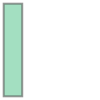

In [299]:
shape(test_aoi)

In [328]:
df = get_area_coverage(test_aoi,[datetime(2022,1,1),datetime(2022,2,1)])

-119.0 38.0
-116.0 40.0
36


100%|███████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 184.25it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')


In [329]:
df.head()

,lon,lat,center_x,center_y,av_cad_hours,n_avail_sensors,geometry
0,-120,38,-119.0,38.375,13.805486,3.0,"POLYGON ((-119.00000 38.00000, -119.00000 39.0..."
1,-120,39,-119.0,39.375,5.689792,3.0,"POLYGON ((-119.00000 39.00000, -119.00000 40.0..."
2,-120,40,-119.0,40.000,11.096389,3.0,"POLYGON ((-119.00000 40.00000, -119.00000 41.0..."
3,-119,38,-118.0,38.375,4.795417,3.0,"POLYGON ((-118.00000 38.00000, -118.00000 39.0..."
4,-119,39,-118.0,39.375,5.856319,3.0,"POLYGON ((-118.00000 39.00000, -118.00000 40.0..."


In [330]:
df.to_file('final_test')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_94349/280259640.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('final_test')


In [313]:
_ = shape2gdf(test_aoi, filename = 'test2', to_file = True)

### Work in progress

### The below cells are just generating quick results lists for debugging

In [ ]:
# aoi = Polygon([[90, 45], [180, 45], [180, 90], [90, 90], [90, 45]])
aoi = Polygon([[-180, 0],[0, 0],[0, -90],[-180, -90],[-180, 0]])
wkt = aoi.wkt
print(wkt)
opts = {
    'platform': asf.PLATFORM.SENTINEL1,
    'processingLevel': [asf.PRODUCT_TYPE.SLC],
    'beamMode': [asf.BEAMMODE.IW],
    'start': '2022-01-01T00:00:00Z',
    'end': '2022-01-31T23:59:59Z'
}
results = asf.search(intersectsWith=wkt,**opts)
print(len(results))

In [ ]:
sent1_forest = format_results_for_sent1(results)

In [ ]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSS30.v2.0']
search_params = {"collections": hls_collections,
                 "bbox": [-90, 0, 0, 90], # list of xmin, ymin, xmax, ymax
                 "datetime": [datetime(2022,1,1), datetime(2022,2,1)],
                 }
search_hls = api.search(**search_params)
hls_collection = search_hls.get_all_items()
g = list(hls_collection)
# d[0].properties

In [ ]:
sent2_forest = format_results_for_hls(g,'sentinel2')

In [ ]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSL30.v2.0']
search_params = {"collections": hls_collections,
                 "bbox": [-180, 0, -90, 90], # list of xmin, ymin, xmax, ymax
                 "datetime": [datetime(2022,1,1), datetime(2022,2,1)],
                 }
search_hls = api.search(**search_params)
hls_collection = search_hls.get_all_items()
d = list(hls_collection)

In [ ]:
land8_forest = format_results_for_hls(d,'landsat8')